<a href="https://colab.research.google.com/github/shaminur-rootcoder/bootstrap-looplab-project/blob/main/final_eq_TimeGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_synthetic.synthesizers.timeseries import TimeGAN
from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading


In [ ]:
#Specific to TimeGANs
seq_len=24
n_seq = 4
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [ ]:
from google.colab import files
files.upload()

Saving data_f.csv to data_f (3).csv


{'data_f.csv': b'latitude,longitude,depth,magnitude\r\n39.0488,27.8443,10.35,5.4\r\n38.3593,39.063,8.06,6.8\r\n38.374,39.131,16.4,5.1\r\n39.6011,26.4261,5.8,5\r\n38.3865,39.1205,8.92,5.2\r\n36.3133,28.4983,18.74,5\r\n40.8818,28.214,7.97,5.8\r\n37.4401,29.4335,10.76,5.5\r\n37.851,29.584,10.92,6\r\n37.5836,38.5036,9.79,5.1\r\n36.0535,31.2135,36.68,5.2\r\n39.5205,26.151,6.24,5.2\r\n36.941,27.332,37.5,5\r\n37.1533,28.647,11.33,5\r\n39.5236,26.1946,7.01,5\r\n36.974,27.523,7.8,6.3\r\n38.7358,27.8156,11.03,5.1\r\n39.5495,26.137,14.16,5.3\r\n39.5303,26.1351,8.72,5.3\r\n37.1206,28.5921,24.75,5\r\n39.5336,26.17,7,5.3\r\n37.1146,28.6045,24.46,5.1\r\n36.9576,27.6236,11.03,5.1\r\n37.5955,38.4866,9.76,5.5\r\n39.564,34.358,13.6,5\r\n39.261,40.217,10.66,5.3\r\n36.1846,29.8853,34.23,5.2\r\n38.8401,37.837,22.41,5\r\n36.5646,35.0361,29.68,5\r\n40.3951,26.3058,6.98,5.3\r\n36.172,30.9301,41.03,5.2\r\n36.692,31.257,65,5\r\n36.048,31.332,43.6,6\r\n39.23,42.28,17,5.2\r\n40.854,27.9235,14.9,5\r\n37.1572,42.443

In [ ]:
eq_df = pd.read_csv('data_f (3).csv')
eq_data = real_data_loading(eq_df.values, seq_len=seq_len)
print(len(eq_data), eq_data[0].shape)

549 (24, 4)


In [60]:
if path.exists('synthesizer_eq.pkl'):
    synth = TimeGAN.load('synthesizer_eq.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(eq_data, train_steps=500)
    synth.save('synthesizer_eq.pkl')

Joint networks training: 100%|██████████| 500/500 [13:50<00:00,  1.66s/it]


In [61]:
synth_data = synth.sample(len(eq_data))
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]

(640, 24, 4)


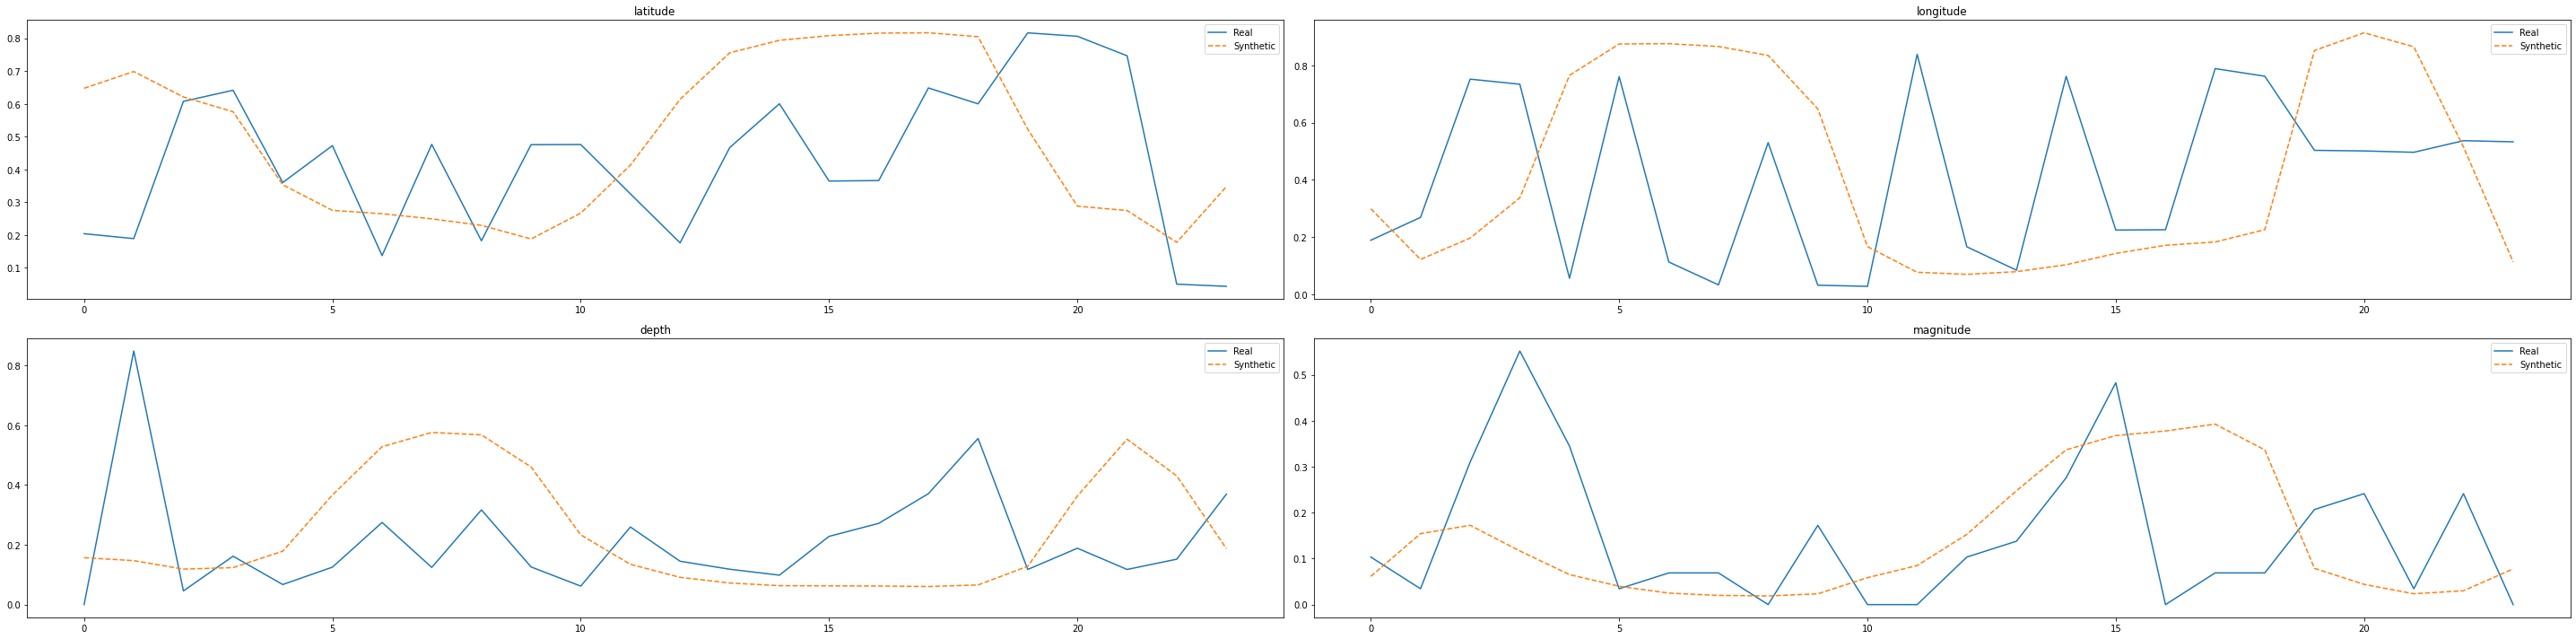

In [69]:
#Reshaping the data
cols = ['latitude','longitude','depth','magnitude']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(eq_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': eq_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

In [70]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(eq_data))[:sample_size]

real_sample = np.asarray(eq_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
eq_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(eq_data_reduced)

pca_real = pd.DataFrame(pca.transform(eq_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((eq_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

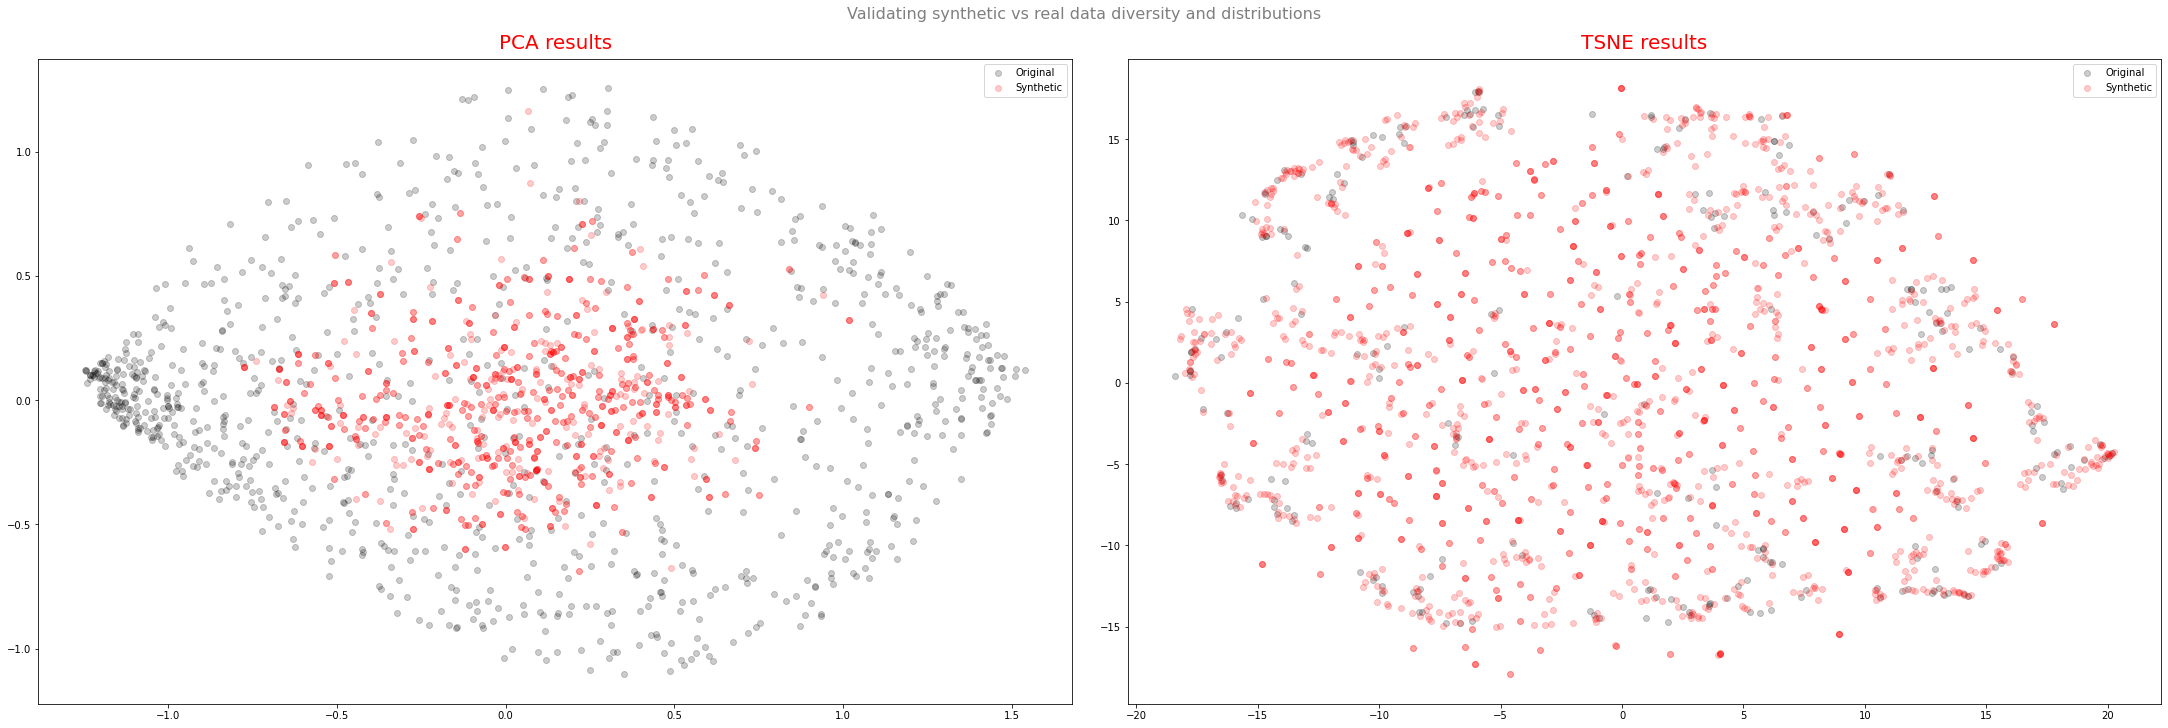

In [73]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(30,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

In [79]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=4,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [80]:
#Prepare the dataset for the regression model
eq_data=np.asarray(eq_data)
synth_data = synth_data[:len(eq_data)]
n_events = len(eq_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_eq_train = eq_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_eq_test = eq_data[test_idx, :seq_len-1, :]
y_eq_test = eq_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_eq_train = eq_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_eq_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_eq_train.shape))

print('Real X test: {}'.format(X_eq_test.shape))
print('Real y test: {}'.format(y_eq_test.shape))

Synthetic X train: (411, 23, 4)
Real X train: (411, 23, 4)
Synthetic y train: (411, 4)
Real y train: (411, 4)
Real X test: (138, 23, 4)
Real y test: (138, 4)


In [81]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_eq_train,
                          y=y_eq_train,
                          validation_data=(X_eq_test, y_eq_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
4/4 [==============================] - 5s 431ms/step - loss: 0.2924 - val_loss: 0.2995
Epoch 2/200
4/4 [==============================] - 0s 96ms/step - loss: 0.2889 - val_loss: 0.2948
Epoch 3/200
4/4 [==============================] - 0s 90ms/step - loss: 0.2824 - val_loss: 0.2902
Epoch 4/200
4/4 [==============================] - 0s 89ms/step - loss: 0.2799 - val_loss: 0.2856
Epoch 5/200
4/4 [==============================] - 0s 75ms/step - loss: 0.2755 - val_loss: 0.2810
Epoch 6/200
4/4 [==============================] - 0s 77ms/step - loss: 0.2693 - val_loss: 0.2764
Epoch 7/200
4/4 [==============================] - 0s 51ms/step - loss: 0.2657 - val_loss: 0.2718
Epoch 8/200
4/4 [==============================] - 0s 55ms/step - loss: 0.2594 - val_loss: 0.2671
Epoch 9/200
4/4 [==============================] - 0s 82ms/step - loss: 0.2568 - val_loss: 0.2623
Epoch 10/200
4/4 [==============================] - 0s 90ms/step - loss: 0.2527 - val_loss: 0.2573
Epoch 11/200
4/4 [

In [82]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_eq_test, y_eq_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
4/4 [==============================] - 2s 132ms/step - loss: 0.2584 - val_loss: 0.2757
Epoch 2/200
4/4 [==============================] - 0s 33ms/step - loss: 0.2548 - val_loss: 0.2711
Epoch 3/200
4/4 [==============================] - 0s 34ms/step - loss: 0.2483 - val_loss: 0.2665
Epoch 4/200
4/4 [==============================] - 0s 35ms/step - loss: 0.2442 - val_loss: 0.2618
Epoch 5/200
4/4 [==============================] - 0s 34ms/step - loss: 0.2402 - val_loss: 0.2571
Epoch 6/200
4/4 [==============================] - 0s 34ms/step - loss: 0.2348 - val_loss: 0.2523
Epoch 7/200
4/4 [==============================] - 0s 35ms/step - loss: 0.2308 - val_loss: 0.2475
Epoch 8/200
4/4 [==============================] - 0s 34ms/step - loss: 0.2267 - val_loss: 0.2427
Epoch 9/200
4/4 [==============================] - 0s 35ms/step - loss: 0.2215 - val_loss: 0.2377
Epoch 10/200
4/4 [==============================] - 0s 34ms/step - loss: 0.2147 - val_loss: 0.2325
Epoch 11/200
4/4 [

In [83]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_eq_test)
synth_predictions = ts_synth.predict(X_eq_test)

metrics_dict = {'r2': [r2_score(y_eq_test, real_predictions),
                       r2_score(y_eq_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_eq_test, real_predictions),
                        mean_absolute_error(y_eq_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_eq_test, real_predictions),
                         mean_squared_log_error(y_eq_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

,r2,MAE,MRLE
Real,-0.10732,0.174279,0.029223
Synthetic,-0.07343,0.177062,0.027906
